# Instalação de Dependências

In [ ]:
%pip install -r requirements.txt

# Informações
Rodadas: 14 com 2 turnos (mandantes diferentes nos jogos)
Por exemplo, se no primeiro turno DFC era o mandante contra TFC, no segundo TFC
Cada turno, está implícito que todos os times devem jogar entre si.

Para cada rodada será rodado o algoritmo de coloração com os times existentes.
As restrições serão de forma que, além daquelas descritas na especificação, se um time já jogou com o outro no mesmo turno então não podem jogar novamente (vizinhos).

Vou tentar colorir com o mínimo de cores possíveis. Se tem a mesma cor quer dizer que pode jogar junto.
Se cor > 


# Códigos Base

In [2]:
from typing import List, Tuple
from dataclasses import dataclass


# Significa que os times dentro desta tupla não
# podem ser mandantes na mesma rodada
@dataclass
class HostRestrict:
    hosts: Tuple[str, str]


# Esse jogo não pode acontencer nesta rodada.
# Atenção: O mandante importa.
@dataclass
class GameRestrict:
    host: str
    other: str


@dataclass
class Team:
    id: int
    name: str

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from typing import Mapping, List, Tuple, Dict


class Graph:
    def __init__(self, nodes: List[Team]):
        self._graph = nx.Graph()
        self._pos: Mapping = None

        # Número de vértices
        self.nodes = nodes
        self.edges: List[Tuple[Team, Team]] = []

        # Lista de adjacência
        self._neighbours = [[] for _ in nodes]

        self._draw_params = {
            "with_labels": True,
            "node_color": "gold",
            "node_size": 100,
            "edge_color": "gray",
            "font_weight": "bold",
            "font_size": 8,
        }

    def neighbours(self, v: Team) -> List[Team]:
        # Função auxiliadora para encontrar vizinhos de um vértice.
        # Subtraímos 1 pois a nossa lista começa em 0.
        return self._neighbours[v.id - 1]
    
    def insert_edge(self, v1: Team, v2: Team):
        self._graph.add_edge(v1.name, v2.name)
        self.edges.append((v1, v2))

        self.neighbours(v1).append(v2)
        self.neighbours(v2).append(v1)

    def has_edge(self, v1: Team, v2: Team):
        v2 in self.neighbours(v1)

    def node_degree(self, v: Team) -> int:
        return len(self.neighbours(v))

    def _reload_pos(self):
        self._pos = nx.spring_layout(self._graph)

    def _load_pos(self):
        if self._pos is None:
            self._reload_pos()

    def _create_view(self, node_colors=None):
        self._load_pos()

        plt.figure(3, figsize=(12, 12))
        draw_params = self._draw_params.copy()
        if node_colors:
            draw_params["node_color"] = node_colors
        print(draw_params)

        nx.draw_networkx(
            self._graph, 
            pos=self._pos, 
            alpha=0.9,  
            **draw_params
            )

   #     nx.draw_networkx(
   #     self._graph, 
   #     pos=self._pos, 
   #     alpha=0.9,
   #     **self._draw_params
   #     )   

    def view(self):
        self._create_view()
        plt.title("Jogos")
        plt.show()

    
    def greedy_coloring_algorithm(self, colors):
        """Assign colors to nodes using the Greedy Coloring Algorithm."""
        
        nodes = sorted(self._graph.nodes(), key=lambda n: self._graph.degree[n], reverse=True)
        color_map = {}

        for node_name in nodes:
           
            node = next(team for team in self.nodes if team.name == node_name)
            
            
            neighbors = self.neighbours(node)

            # Step 1: pegar as cores dos vizinhos
            forbidden_colors = {color_map[neighbor.name] 
                                for neighbor in neighbors
                                if neighbor.name in color_map}
            # Step 2: usar a primeira cor que não é proibida
            for color in colors:
                if color not in forbidden_colors:  
                    color_map[node.name] = color
                    break
        return color_map


    def view_colored(self):
        """Displays the graph with nodes colored according to the coloring algorithm."""
        colors = ["red", "blue", "green", "yellow", "orange", "purple", "cyan",
                  "magenta", "brown", "pink", "lime", "teal", "gold", "violet"]
        color_map = self.greedy_coloring_algorithm(colors)
        print(f"nodes {self._graph.nodes}")
        print(f'color_map: {color_map}')

        # Assign colors based on the computed color mapping
        #node_colors = [color_palette[color_map[node.name] % len(color_palette)] for node in self.nodes]
        node_colors = [color_map[node] for node in self._graph.nodes]
        
        print(f'node_colors: {node_colors}')
        print(f'Number of nodes: {len(node_colors)}')

        self._create_view(node_colors)
        plt.title("Jogos - Colored Graph")
        plt.show()


In [189]:
from typing import Dict, Set


class Game:
    def __init__(self, teams: List[str], rounds: List[int]):
        self.teams = teams
        self.rounds = rounds
        self.max_rounds = sum(rounds)

        self.rounds_played: List[List[Tuple[int]]] = []

        self.host_restrictions: List[HostRestrict] = []
        self.game_restrictions: List[List[GameRestrict]] = [
            [] for _ in range(self.max_rounds)
        ]

        self._teams_map: Dict[str, int] = {}
        self._load_teams_map()

    def _load_teams_map(self):
        for i, team in enumerate(self.teams):
            self._teams_map[team] = i

    def lookup_team(self, team: str) -> int:
        return self._teams_map[team]

    def ruler_teams(self) -> List[str]:
        ruler_teams: List[str] = []
        for team in self.teams:
            ruler_teams.append(f"M{team}")
        for team in self.teams:
            ruler_teams.append(f"N{team}")

        return ruler_teams
    
    def ruler_teams_full(self) -> List[str]:
        ruler_teams: List[str] = []
        for i, team in enumerate(self.teams):
            ruler_teams.append(Team(i, f"M{team}"))
        for i, team in enumerate(self.teams):
            ruler_teams.append(Team(i+len(self.teams), f"N{team}"))

        return ruler_teams

    def lookup_ruler_team(self, team: str, ruler: bool) -> int:
        team_id = self.lookup_team(team)
        return (
            Team(team_id, f"M{team}")
            if ruler
            else Team(team_id + len(self.teams), f"N{team}")
        )

    def insert_host_restriction(self, hosts: Tuple[str, str]):
        self.host_restrictions.append(HostRestrict(hosts))

    def insert_game_restriction(self, rounds: List[int], host: str, other: str):
        restrict = GameRestrict(host, other)
        for round in rounds:
            if round > self.max_rounds:
                raise ValueError(f"O jogo tem apenas {self.rounds} rodadas.")

            self.game_restrictions[round - 1].append(restrict)

    def build_graph(self):
        # Criar grafo com times duplicados
        # Teams terão inicial M para mandantes e N para não-mandantes.
        graph = Graph(self.ruler_teams_full())

        # Obviamente existirá uma restrição para mesmos times
        for team in self.teams:
            ruler, not_ruler = [self.lookup_ruler_team(team, b) for b in [True, False]]
            graph.insert_edge(ruler, not_ruler)

        # Além disso mandantes não podem fazer jogos com outros mandantes
        # E não-mandantes não podem fazer jogos com outros.
        for team1 in self.teams:
            mteam1 = self.lookup_ruler_team(team1, True)
            nteam1 = self.lookup_ruler_team(team1, False)

            for team2 in self.teams:
                mteam2 = self.lookup_ruler_team(team2, True)
                nteam2 = self.lookup_ruler_team(team2, False)

                graph.insert_edge(mteam1, mteam2)
                graph.insert_edge(nteam1, nteam2)

        round = len(self.rounds_played)
        for restriction in self.game_restrictions[round - 1]:
            host = self.lookup_ruler_team(restriction.host, True)
            other = self.lookup_ruler_team(restriction.other, False)

            graph.insert_edge(host, other)

        for restriction in self.host_restrictions:
            first, second = restriction.hosts
            host_1 = self.lookup_ruler_team(first, True)
            host_2 = self.lookup_ruler_team(second, True)

            graph.insert_edge(host_1, host_2)

        return graph
    
    def min_color(self, colors: List[List[Team]], exclude: Set[int]) -> int:
        min_id, min_color = None, None
        for i, color in enumerate(colors):
            if i in exclude or len(color) >= 2:
                continue

            if min_color is None or len(color) < min_color:
                min_id = i
                min_color = len(color)

        return min_id
    
    def color_graph(self, graph: Graph) -> Tuple[List[List[Team]], List[int]]:
        colors: List[List[Team]] = []
        color_map: List[int] = [None for _ in graph.nodes]
        chosen_teams: Set[str] = set()

        for v in graph.nodes:
            # if len(colors) == 0:
            #     colors.append([v]) 
            #     color_map[v.id] = 0
            #     break
            team = v.name[1:]
            if team in chosen_teams:
                continue

            neighbours = graph.neighbours(v)
            exclude = set()
            for neighbour in neighbours:
                if color_map[neighbour.id] is not None:
                    exclude.add(color_map[neighbour.id])
            
            color = self.min_color(colors, exclude)
            if color is None:
                color_map[v.id] = len(colors)
                colors.append([v])
            else:
                color_map[v.id] = color
                colors[color].append(v) 

            chosen_teams.add(team)
            
        
        return colors, color_map
    
    def play_round(self) -> List[Tuple[int]]:
        graph = self.build_graph()
        colors, color_map = self.color_graph(graph)
        print(colors)
        print(color_map)


In [190]:
times, rounds = ["DFC", "TFC", "AFC", "LFC", "FFC", "OFC", "CFC"], [7, 7]
game = Game(times, rounds)

game.insert_game_restriction([1, 14], "DFC", "CFC")

game.insert_host_restriction(("TFC", "OFC"))
game.insert_host_restriction(("AFC", "FFC"))

game.insert_game_restriction([7, 13], "LFC", "FFC")
game.insert_game_restriction([10, 11], "OFC", "LFC")
game.insert_game_restriction([12, 13], "AFC", "FFC")
game.insert_game_restriction([2, 3], "CFC", "TFC")

{'with_labels': True, 'node_color': 'gold', 'node_size': 100, 'edge_color': 'gray', 'font_weight': 'bold', 'font_size': 8}


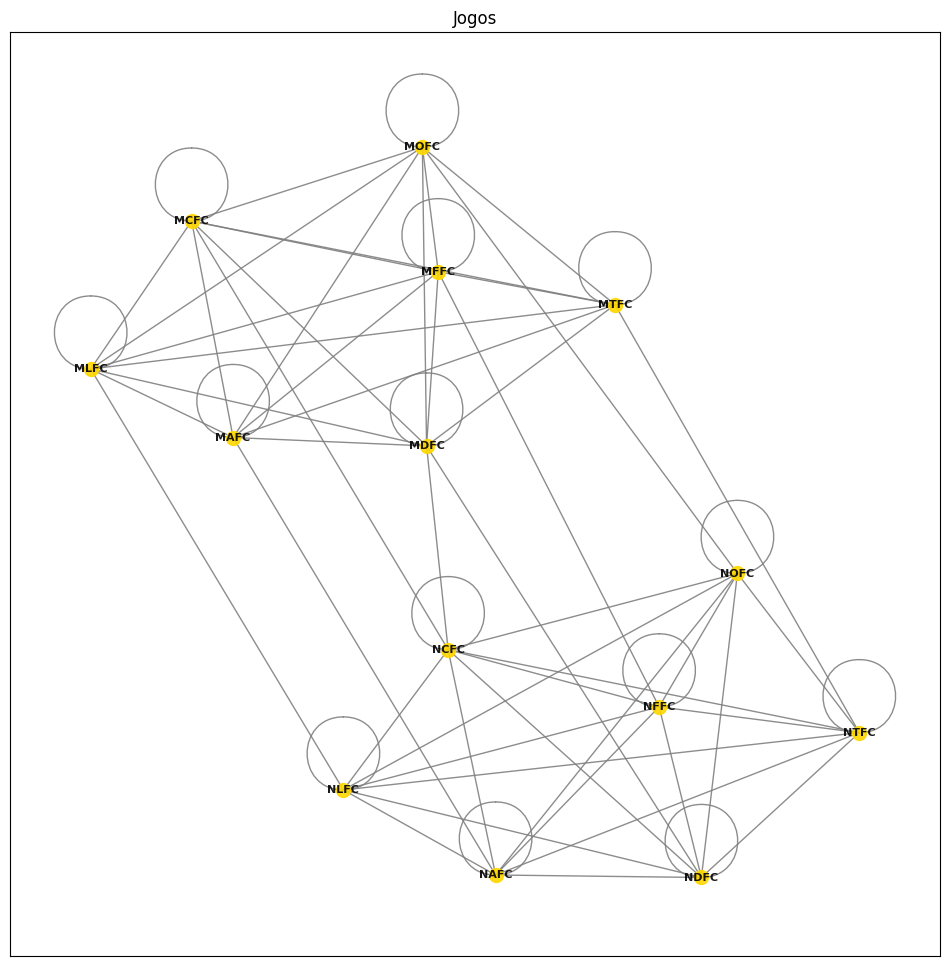

In [191]:
graph = game.build_graph()
graph.view()

nodes ['MDFC', 'NDFC', 'MTFC', 'NTFC', 'MAFC', 'NAFC', 'MLFC', 'NLFC', 'MFFC', 'NFFC', 'MOFC', 'NOFC', 'MCFC', 'NCFC']
color_map: {'MDFC': 'red', 'NCFC': 'blue', 'NDFC': 'green', 'MTFC': 'blue', 'NTFC': 'red', 'MAFC': 'green', 'NAFC': 'yellow', 'MLFC': 'yellow', 'NLFC': 'orange', 'MFFC': 'orange', 'NFFC': 'purple', 'MOFC': 'purple', 'NOFC': 'cyan', 'MCFC': 'cyan'}
node_colors: ['red', 'green', 'blue', 'red', 'green', 'yellow', 'yellow', 'orange', 'orange', 'purple', 'purple', 'cyan', 'cyan', 'blue']
Number of nodes: 14
{'with_labels': True, 'node_color': ['red', 'green', 'blue', 'red', 'green', 'yellow', 'yellow', 'orange', 'orange', 'purple', 'purple', 'cyan', 'cyan', 'blue'], 'node_size': 100, 'edge_color': 'gray', 'font_weight': 'bold', 'font_size': 8}


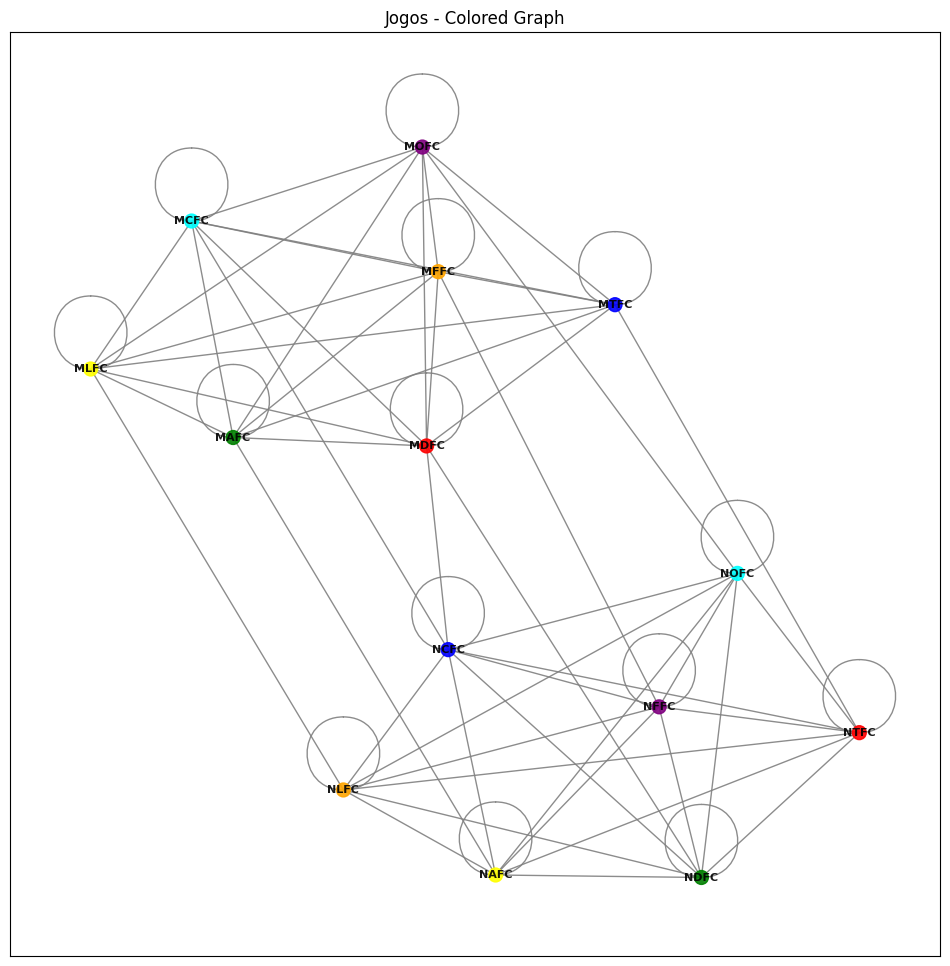

In [192]:
graph.view_colored()

In [105]:
game.play_round()

[[Team(id=0, name='MDFC')], [Team(id=1, name='MTFC')], [Team(id=2, name='MAFC')], [Team(id=3, name='MLFC')], [Team(id=4, name='MFFC')], [Team(id=5, name='MOFC')], [Team(id=6, name='MCFC')]]
[0, 1, 2, 3, 4, 5, 6, None, None, None, None, None, None, None]
